In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Let's start by pulling in the .csv we made in our GPI religion pull
df = pd.read_csv('gpi_by_rel.csv', index_col=0)

print(df.head(10))

             2019 rank  2019 score  Christians  Muslims  Unaffiliated  Hindus  \
Afghanistan        158       3.300         0.1     99.7           0.1     0.1   
Albania             51       1.821        18.0     80.3           1.4     0.1   
Algeria            111       2.219         0.2     97.9           1.8     0.1   
Angola              77       2.012        90.5      0.2           5.1     0.1   
Argentina           75       1.989        85.2      1.0          12.2     0.1   
Armenia            118       2.294        98.5      0.1           1.3     0.1   
Australia           13       1.419        67.3      2.4          24.2     1.4   
Austria              4       1.291        80.4      5.4          13.5     0.1   
Azerbaijan         130       2.425         3.0     96.9           0.1     0.1   
Bahrain            124       2.357        14.5     70.3           1.9     9.8   

             Buddhists  Folk Religions  Other  Jews    All  
Afghanistan        0.1             0.1    0.1  

In [3]:
#let's sort it by their rank and see the top ten and bottom ten
dfa = df.sort_values(df.columns[0])
print(dfa.head(10))
print(dfa.tail(10))


             2019 rank  2019 score  Christians  Muslims  Unaffiliated  Hindus  \
Iceland              1       1.072        95.0      0.2           3.5     0.3   
New Zealand          2       1.221        57.0      1.2          36.6     2.1   
Portugal             3       1.274        91.9      0.3           7.5     0.1   
Austria              4       1.291        80.4      5.4          13.5     0.1   
Denmark              5       1.316        83.5      4.1          11.8     0.4   
Canada               6       1.327        69.0      2.1          23.7     1.4   
Singapore            7       1.347        18.2     14.3          16.4     5.2   
Slovenia             8       1.355        78.4      3.6          18.0     0.1   
Japan                9       1.369         1.6      0.2          57.0     0.1   
Switzerland         10       1.375        72.7      4.9          20.9     0.5   

             Buddhists  Folk Religions  Other  Jews    All  
Iceland            0.4             0.5    0.2  

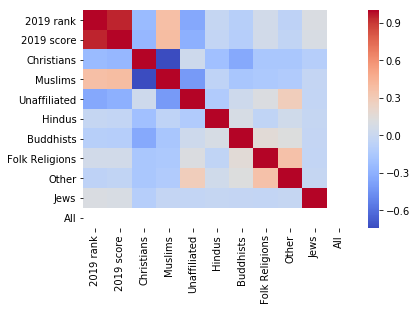

In [4]:
#We are primarily looking for correlation between score and religion, so lets plot a heatmap of correlation matrix and do some EDA
corrmat = df.corr()
sns.heatmap(data=corrmat, cmap='coolwarm')
plt.show()

#In fact, according to the correlation matrix, Islam is the only faith that seems to have a positive correlation.
#(In this case, a positive value means a country is less safe remember, so you don't want a positive correlation.)

In [5]:
#to make later analysis easier, lets make a list with just the religions names
religions = df.columns[2:10]
print(religions)

Index(['Christians', 'Muslims', 'Unaffiliated', 'Hindus', 'Buddhists',
       'Folk Religions', 'Other', 'Jews'],
      dtype='object')


In [6]:
#Let's define a function to give us the pearson correlation coeficient

def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [7]:
#Let's find the pearson correlation for religions and GPI
r_list = []

for rel in religions:
    r = pearson_r(df['2019 score'], df[rel])
    print('pearson coeficient of {} to GPI score:'.format(rel), r)
    r_list.append(r)

#and store it in a dictionary in case we want it later    
religion_pearsons = dict(zip(religions, r_list))


pearson coeficient of Christians to GPI score: -0.25970772274771947
pearson coeficient of Muslims to GPI score: 0.3936161390085939
pearson coeficient of Unaffiliated to GPI score: -0.3026166759787703
pearson coeficient of Hindus to GPI score: -0.02919532095869543
pearson coeficient of Buddhists to GPI score: -0.09969837225403802
pearson coeficient of Folk Religions to GPI score: 0.05447399995422289
pearson coeficient of Other to GPI score: -0.0392402944362994
pearson coeficient of Jews to GPI score: 0.09525459986131775


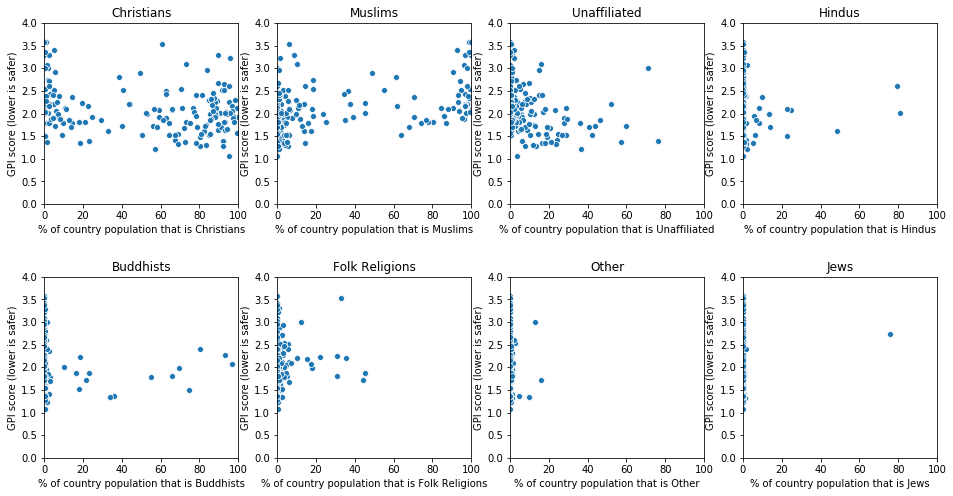

In [8]:
#so far most of those have very week pearson coefficients. Christianity, Islam, and Unaffiliated are the only ones
#to have an absolute value over 0.1 even.

#Let's make some very basic scatterplots of each religion and see how things look to the naked eye.

rel_range = np.arange(2, 10)
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.4)

for i in rel_range:
    ax = plt.subplot(2, 4, (i-1))
    sns.scatterplot(data=df, x=df.columns[i], y='2019 score')
    plt.xlabel('% of country population that is {}'.format(df.columns[i]))
    plt.ylabel('GPI score (lower is safer)')
    plt.title(df.columns[i])
    plt.xlim(0,100)
    plt.ylim(0, 4)
                     
plt.show()

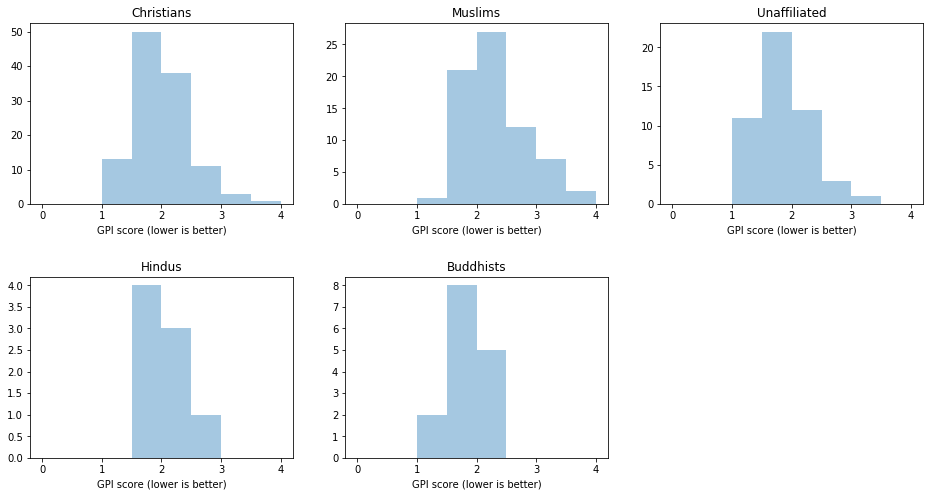

In [9]:
#EDA shows that none of them have a very obvious visual correlation
#in the second row it looks like we don't have enough data points to focus on Jewdaism, Other, or Folk Religions,
#since they don't make up a majority in any country (except Jewdaism which only has one data point)
#But we'll continue to focus on others to see if we can find any statistical trends.

#One of the things we notice above is that most of the religions are primarily 0 or close to 0 values that may be
#skewing the correlation.  Lets also examine how things look if we only count occurances for a religion if that
#religion makes up at least 10% of a population

#this time we only need columns 2 through 7 since we aren't going to focus on the last three religions moving foward
rel_range = np.arange(2, 7)
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.4)

for i in rel_range:
    ax = plt.subplot(2, 3, (i-1))
    sns.distplot(df['2019 score'][df[df.columns[i]] >= 10], kde=False, bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4])
    plt.title(df.columns[i])
    plt.xlabel('GPI score (lower is better)')

                     
plt.show()

In [12]:
#initialize an empty p-val list

#For loop over each religion we want to check

# Initialize permutation replicates: perm_replicates
perm_replicates = np.empty(10000)

# Draw replicates
for i in range(10000):
    # Permute Muslim measurments: muslims_permuted
    muslims_permuted = np.random.permutation(df['Muslims'])

    # Compute Pearson correlation
    perm_replicates[i] = pearson_r(muslims_permuted, df['2019 score'])

# Compute p-value: p
p = np.sum(perm_replicates >= religion_pearsons['Muslims']) / len(perm_replicates)
print('p-val =', p)

p-val = 0.0


In [ ]:
#p-value of 0 with 10000 bootstrap permutations means that our p-value is less than 0.0001
#that is highly statistically relevant, though the pearson coeficient of roughly 0.4 is not that strong.
#this does mean that there is definitely SOME correlation between Islam and GPI score,
#But it doesn't mean causality! 